In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
from scipy import stats

In [3]:
import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)

In [4]:
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_select, pad_seqs

In [5]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# RNN

In [6]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):

    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    for i in range(len(sequence[0])):
        output, hidden = model.forward(sequence[0][i], hidden)
    #Compare final output to target
    loss = criterion(output,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return output, loss.item()

def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model, train_data, test_data, epochs, verbose = False):

    model.train()
    loss_history = []
    acc_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history.append(lossTotal)
        acc = test_acc(model, test_data, hidden_size)
        acc_history.append(acc)

    print(f'loss: {round(lossTotal,1)} ')
    print(f'accuracy: {round(acc,2)} ')
    return loss_history, acc_history

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    correct = 0
    for x,y in testdata:
        hidden = torch.zeros(1, hidden_size)[0]
        for step in x[0]:
            hidden, y_hat = model.get_activations(step,hidden)
        correct += sum(torch.round(y) == torch.round(y_hat)).item()/len(y)
    acc = correct/len(testdata)
    
    if verbose:
        print('test accuracy: %f ' % (acc))

    return acc

def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t
    

# 1 step operation transfer 

In [60]:
batchsize = 1
scale = 4

seqs1 = generate_sequences( ['+', '*'], [2],len_seq=1, init_values = [1,2,5,7], rand = False, cue_dict = False)
padseqs1 = pad_select(seqs1, [0])
train_inputs1 = convert_seq2inputs(padseqs1, num_classes=14, seq_len=8)
train1 = DataLoader(train_inputs1, batch_size=batchsize, shuffle=True)

seqs2 = generate_sequences( ['+', '*'], [2], len_seq=1, init_values = [3,4,6,9], rand = False, cue_dict = False)
padseqs2 = pad_select(seqs2, [0])
train_inputs2 = convert_seq2inputs(padseqs2, num_classes=14, seq_len=8)
train2 = DataLoader(train_inputs2, batch_size=batchsize, shuffle=True)
savepath = '../results/primitives/op_100123/'

In [131]:
len(padseqs1)

24

In [92]:
figpath = '../figures/op_100123/'

In [53]:
num_classes = 14
input_size = num_classes
output_size = batchsize
hidden_size = 20
num_layers = 1
learningRate = 0.0005

In [54]:
one_shot_acc = []
losses=[]
accs = []
losses_rand = []
accs_rand = []

num_sims = 100
epochs = 400

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train1, train1, epochs)
    
    acc_1shot = test_acc(model, train2, hidden_size, verbose = True)
    one_shot_acc.append(acc_1shot)
    print('----- 1 shot accuracy ------')
    
    model2 = shuffle_weights(model)
    
    loss2, acc2 = run_acc(model, train2, train2, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model2, train2, train2, epochs)
    losses_rand.append(loss3)
    accs_rand.append(acc3)


### rep 0  ###
loss: 0.0 
accuracy: 1.0 
test accuracy: 0.750000 
----- 1 shot accuracy ------
loss: 0.9 
accuracy: 1.0 
loss: 4.0 
accuracy: 0.38 
### rep 1  ###
loss: 1.2 
accuracy: 0.75 
test accuracy: 0.875000 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 5.2 
accuracy: 0.38 
### rep 2  ###
loss: 1.8 
accuracy: 0.5 
test accuracy: 0.250000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.4 
accuracy: 1.0 
### rep 3  ###
loss: 0.7 
accuracy: 1.0 
test accuracy: 0.875000 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 1.7 
accuracy: 0.75 
### rep 4  ###
loss: 2.4 
accuracy: 0.62 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 2.2 
accuracy: 0.62 
### rep 5  ###
loss: 1.3 
accuracy: 0.75 
test accuracy: 0.750000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 2.7 
accuracy: 0.38 
### rep 6  ###
loss: 0.5 
accuracy: 1.0 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.1 
accu

loss: 3.1 
accuracy: 0.5 
test accuracy: 0.500000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 2.3 
accuracy: 0.62 
### rep 56  ###
loss: 2.0 
accuracy: 0.62 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 2.0 
accuracy: 0.62 
### rep 57  ###
loss: 5.5 
accuracy: 0.38 
test accuracy: 0.500000 
----- 1 shot accuracy ------
loss: 0.2 
accuracy: 1.0 
loss: 3.0 
accuracy: 0.62 
### rep 58  ###
loss: 0.8 
accuracy: 0.88 
test accuracy: 0.875000 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 1.2 
accuracy: 0.62 
### rep 59  ###
loss: 2.4 
accuracy: 0.5 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 0.6 
accuracy: 0.88 
### rep 60  ###
loss: 2.4 
accuracy: 0.62 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 2.1 
accuracy: 0.62 
### rep 61  ###
loss: 0.2 
accuracy: 1.0 
test accuracy: 0.750000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1

In [63]:
# save
fileObject = open(savepath + 'loss_1step_set1set2', 'wb')
pickle.dump(losses , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_1step_set1set2', 'wb')
pickle.dump(accs , fileObject)
fileObject.close()

fileObject = open(savepath + 'loss_1step_set2', 'wb')
pickle.dump(losses_rand , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_1step_set2', 'wb')
pickle.dump(accs_rand , fileObject)
fileObject.close()

fileObject = open(savepath + 'acc_1step_1shot_set2', 'wb')
pickle.dump(one_shot_acc, fileObject)
fileObject.close()

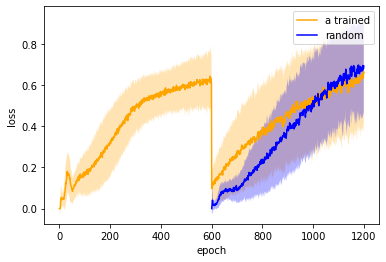

In [96]:
lr = np.array(accs).T
r = np.array(accs_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['a trained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = epochs)

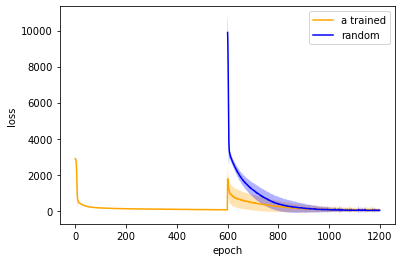

In [97]:
lr = np.array(losses).T
r = np.array(losses_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['a trained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = epochs)

In [82]:
## change cue and init

batchsize = 1
scale = 4

seqs1 = generate_sequences( ['+', '*'], [2, 3, 4],len_seq=1, init_values = [1,2,5,7], rand = False, cue_dict = False)
padseqs1 = pad_select(seqs1, [0])
train_inputs1 = convert_seq2inputs(padseqs1, num_classes=14, seq_len=8)
train1 = DataLoader(train_inputs1, batch_size=batchsize, shuffle=True)

seqs2 = generate_sequences( ['+', '*'], [1,4,7], len_seq=1, init_values = [3,4,6,9], rand = False, cue_dict = False)
padseqs2 = pad_select(seqs2, [0])
train_inputs2 = convert_seq2inputs(padseqs2, num_classes=14, seq_len=8)
train2 = DataLoader(train_inputs2, batch_size=batchsize, shuffle=True)
savepath = '../results/primitives/op_100123/'

In [83]:
one_shot_acc = []
losses=[]
accs = []
losses_rand = []
accs_rand = []

num_sims = 100
epochs = 600

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train1, train1, epochs)
    
    acc_1shot = test_acc(model, train2, hidden_size, verbose = True)
    one_shot_acc.append(acc_1shot)
    print('----- 1 shot accuracy ------')
    
    model2 = shuffle_weights(model)
    
    loss2, acc2 = run_acc(model, train2, train2, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model2, train2, train2, epochs)
    losses_rand.append(loss3)
    accs_rand.append(acc3)

# save
fileObject = open(savepath + 'loss_1step_set1set2', 'wb')
pickle.dump(losses , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_1step_set1set2', 'wb')
pickle.dump(accs , fileObject)
fileObject.close()

fileObject = open(savepath + 'loss_1step_set2', 'wb')
pickle.dump(losses_rand , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_1step_set2', 'wb')
pickle.dump(accs_rand , fileObject)
fileObject.close()

fileObject = open(savepath + 'acc_1step_1shot_set2', 'wb')
pickle.dump(one_shot_acc, fileObject)
fileObject.close()

### rep 0  ###
loss: 81.9 
accuracy: 0.54 
test accuracy: 0.125000 
----- 1 shot accuracy ------
loss: 3.3 
accuracy: 0.96 
loss: 20.3 
accuracy: 0.83 
### rep 1  ###
loss: 59.6 
accuracy: 0.83 
test accuracy: 0.125000 
----- 1 shot accuracy ------
loss: 3.0 
accuracy: 0.88 
loss: 14.9 
accuracy: 0.67 
### rep 2  ###
loss: 73.8 
accuracy: 0.58 
test accuracy: 0.041667 
----- 1 shot accuracy ------
loss: 2.1 
accuracy: 0.92 
loss: 1.5 
accuracy: 0.96 
### rep 3  ###
loss: 89.8 
accuracy: 0.75 
test accuracy: 0.250000 
----- 1 shot accuracy ------
loss: 97.0 
accuracy: 0.38 
loss: 6.3 
accuracy: 0.83 
### rep 4  ###
loss: 12.9 
accuracy: 0.54 
test accuracy: 0.125000 
----- 1 shot accuracy ------
loss: 8.5 
accuracy: 0.71 
loss: 7.5 
accuracy: 0.67 
### rep 5  ###
loss: 31.7 
accuracy: 0.46 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 67.4 
accuracy: 0.54 
loss: 3.5 
accuracy: 0.92 
### rep 6  ###
loss: 94.9 
accuracy: 0.75 
test accuracy: 0.208333 
----- 1 shot accuracy 

loss: 3.6 
accuracy: 0.88 
### rep 54  ###
loss: 100.5 
accuracy: 0.71 
test accuracy: 0.250000 
----- 1 shot accuracy ------
loss: 193.6 
accuracy: 0.25 
loss: 33.2 
accuracy: 0.42 
### rep 55  ###
loss: 15.3 
accuracy: 0.79 
test accuracy: 0.291667 
----- 1 shot accuracy ------
loss: 91.3 
accuracy: 0.62 
loss: 1.1 
accuracy: 1.0 
### rep 56  ###
loss: 34.0 
accuracy: 0.5 
test accuracy: 0.041667 
----- 1 shot accuracy ------
loss: 1.2 
accuracy: 1.0 
loss: 15.3 
accuracy: 0.5 
### rep 57  ###
loss: 8.3 
accuracy: 0.79 
test accuracy: 0.166667 
----- 1 shot accuracy ------
loss: 0.5 
accuracy: 0.96 
loss: 15.0 
accuracy: 0.46 
### rep 58  ###
loss: 2.7 
accuracy: 0.88 
test accuracy: 0.333333 
----- 1 shot accuracy ------
loss: 0.8 
accuracy: 1.0 
loss: 3.1 
accuracy: 0.92 
### rep 59  ###
loss: 60.9 
accuracy: 0.5 
test accuracy: 0.083333 
----- 1 shot accuracy ------
loss: 17.8 
accuracy: 0.79 
loss: 8.2 
accuracy: 0.62 
### rep 60  ###
loss: 3.2 
accuracy: 0.62 
test accuracy: 0.0

In [98]:
with open(savepath + 'loss_1step_set1set2', 'rb') as file:
    losses = pickle.load(file)
with open(savepath + 'acc_1step_set1set2', 'rb') as file:
    accs = pickle.load(file)
with open(savepath + 'loss_1step_set2', 'rb') as file:
    losses_rand = pickle.load(file)
with open(savepath + 'acc_1step_set2', 'rb') as file:
    accs_rand = pickle.load(file)
with open(savepath + 'acc_1step_1shot_set2', 'rb') as file:
    one_shot1 = pickle.load(file)

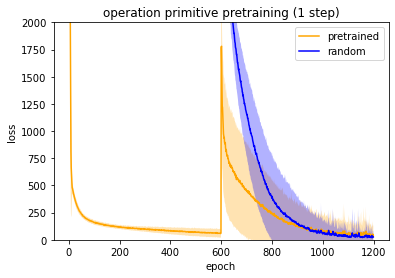

In [99]:
lr = np.array(losses).T
r = np.array(losses_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = epochs)
plt.title('operation primitive pretraining (1 step)')
plt.ylim(0,2000)
plt.savefig(figpath+'loss_1step.png')

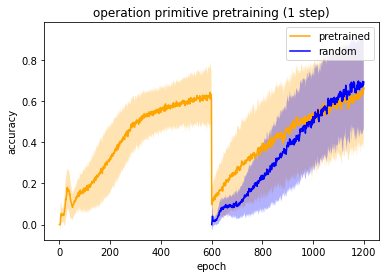

In [94]:
lr = np.array(accs).T
r = np.array(accs_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = 600)
plt.title('operation primitive pretraining (1 step)')
plt.ylabel('accuracy')
plt.savefig(figpath+'acc_1step.png')

In [103]:
np.std(one_shot_acc)

0.10138879375946831

Text(0.5, 0, 'accuracy')

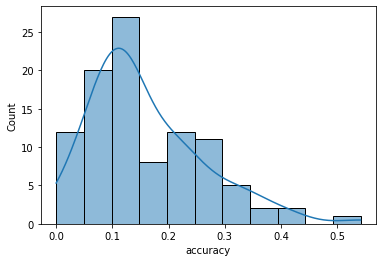

In [102]:
import seaborn as sns
sns.histplot(one_shot1, kde=True)
plt.xlabel('accuracy')

In [104]:
stats.ttest_1samp(one_shot_acc, 0, alternative = 'greater')

Ttest_1sampResult(statistic=15.660844354747693, pvalue=7.617905362249578e-29)

# 2 step operation transfer

In [64]:
batchsize = 1
scale = 8

seqs1 = generate_sequences( ['+', '*'], [2, 3, 4],len_seq=2, init_values = [1,2,5,7], rand = False, cue_dict = False)
padseqs1 = pad_select(seqs1, [0,1])
train_inputs1 = convert_seq2inputs(padseqs1, num_classes=14, seq_len=8)
train1 = DataLoader(train_inputs1, batch_size=batchsize, shuffle=True)

seqs2 = generate_sequences( ['+', '*'], [1,4,7], len_seq=2, init_values = [3,4,6,9], rand = False, cue_dict = False)
padseqs2 = pad_select(seqs2, [0,1])
train_inputs2 = convert_seq2inputs(padseqs2, num_classes=14, seq_len=8)
train2 = DataLoader(train_inputs2, batch_size=batchsize, shuffle=True)

print(len(train1))
print(len(train2))

16
16


In [65]:
one_shot_acc = []
losses=[]
accs = []
losses_rand = []
accs_rand = []

num_sims = 100
epochs = 700

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train1, train1, epochs)
    
    acc_1shot = test_acc(model, train2, hidden_size, verbose = True)
    one_shot_acc.append(acc_1shot)
    print('----- 1 shot accuracy ------')
    
    model2 = shuffle_weights(model)
    
    loss2, acc2 = run_acc(model, train2, train2, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model2, train2, train2, epochs)
    losses_rand.append(loss3)
    accs_rand.append(acc3)

# save
fileObject = open(savepath + 'loss_2step_set1set2', 'wb')
pickle.dump(losses , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_2step_set1set2', 'wb')
pickle.dump(accs , fileObject)
fileObject.close()

fileObject = open(savepath + 'loss_2step_set2', 'wb')
pickle.dump(losses_rand , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_2step_set2', 'wb')
pickle.dump(accs_rand , fileObject)
fileObject.close()

fileObject = open(savepath + 'acc_2step_1shot_set2', 'wb')
pickle.dump(one_shot_acc, fileObject)
fileObject.close()

### rep 0  ###
loss: 1.5 
accuracy: 0.94 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.5 
accuracy: 1.0 
loss: 1.5 
accuracy: 1.0 
### rep 1  ###
loss: 2.1 
accuracy: 0.75 
test accuracy: 0.750000 
----- 1 shot accuracy ------
loss: 1.4 
accuracy: 0.81 
loss: 0.9 
accuracy: 1.0 
### rep 2  ###
loss: 3.1 
accuracy: 0.75 
test accuracy: 0.562500 
----- 1 shot accuracy ------
loss: 3.1 
accuracy: 0.81 
loss: 0.3 
accuracy: 1.0 
### rep 3  ###
loss: 4.8 
accuracy: 0.88 
test accuracy: 0.687500 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 29.0 
accuracy: 0.06 
### rep 4  ###
loss: 1.2 
accuracy: 1.0 
test accuracy: 0.687500 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.1 
accuracy: 1.0 
### rep 5  ###
loss: 0.3 
accuracy: 1.0 
test accuracy: 0.750000 
----- 1 shot accuracy ------
loss: 0.2 
accuracy: 1.0 
loss: 0.3 
accuracy: 1.0 
### rep 6  ###
loss: 0.7 
accuracy: 1.0 
test accuracy: 0.562500 
----- 1 shot accuracy ------
loss: 0.0 
accu

loss: 1.8 
accuracy: 0.75 
test accuracy: 0.687500 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 6.1 
accuracy: 0.94 
### rep 56  ###
loss: 13.6 
accuracy: 0.56 
test accuracy: 0.500000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.6 
accuracy: 1.0 
### rep 57  ###
loss: 1.4 
accuracy: 0.81 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.2 
accuracy: 1.0 
loss: 13.2 
accuracy: 0.56 
### rep 58  ###
loss: 0.6 
accuracy: 1.0 
test accuracy: 0.625000 
----- 1 shot accuracy ------
loss: 0.2 
accuracy: 0.94 
loss: 0.3 
accuracy: 0.94 
### rep 59  ###
loss: 0.4 
accuracy: 1.0 
test accuracy: 0.937500 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.1 
accuracy: 1.0 
### rep 60  ###
loss: 2.4 
accuracy: 0.69 
test accuracy: 0.500000 
----- 1 shot accuracy ------
loss: 0.2 
accuracy: 1.0 
loss: 1.5 
accuracy: 0.94 
### rep 61  ###
loss: 1.3 
accuracy: 0.88 
test accuracy: 0.687500 
----- 1 shot accuracy ------
loss: 0.3 
accuracy:

In [115]:
savepath = '../results/primitives/op_100123_protect/'

In [116]:
with open(savepath + 'loss_2step_set1set2', 'rb') as file:
    losses = pickle.load(file)
with open(savepath + 'acc_2step_set1set2', 'rb') as file:
    accs = pickle.load(file)
with open(savepath + 'loss_2step_set2', 'rb') as file:
    losses_rand = pickle.load(file)
with open(savepath + 'acc_2step_set2', 'rb') as file:
    accs_rand = pickle.load(file)
with open(savepath + 'acc_2step_1shot_set2', 'rb') as file:
    one_shot1 = pickle.load(file)

Text(0.5, 0, '1 shot acc')

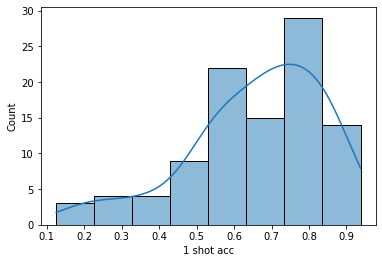

In [126]:
import seaborn as sns
sns.histplot(one_shot1, kde= True)
plt.xlabel('1 shot acc')

In [128]:
np.std(one_shot1)

0.18015184567469747

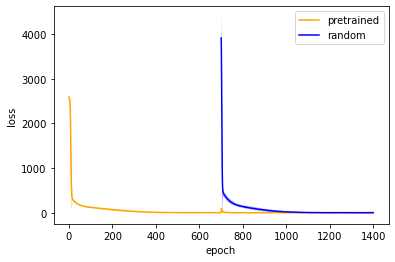

In [129]:
lr = np.array(losses).T
r = np.array(losses_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = 700)
#plt.ylim(0,1000)

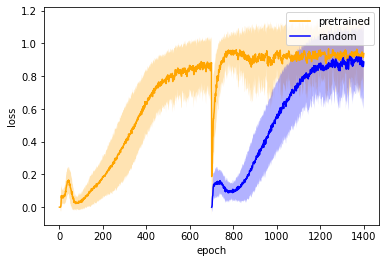

In [121]:
lr = np.array(accs).T
r = np.array(accs_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = 700)